In [ ]:
#!pip install numpy==1.22.*
#!pip install queueing_tool

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import math
import itertools as it
from operator import itemgetter
from matplotlib import pyplot as plt, dates as md
from scipy.special import factorial
from scipy.stats import norm, poisson, gamma, probplot, ks_2samp, kstest
from scipy.optimize import minimize, Bounds
from scipy.integrate import quad
from shapely.geometry import Point, Polygon

C:\Users\souza.daniel_ifood\anaconda3\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12

In [3]:
def amostra_agrupada(df, grupo, tam, n_min, n_max, semente):
    df_filtrado = df.groupby(grupo).filter(lambda x: (len(x) >= n_min) & (len(x) <= n_max))
    amostra_df_filtrado = pd.Series(df_filtrado[grupo].unique()).sample(tam, random_state=semente)
    
    return df[df[grupo].isin(amostra_df_filtrado)]


def plot_agrupado(df, grupo, x, y, agr, cols):
    grps = df.groupby(grupo, sort=False)
    rows = int(grps.ngroups / cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))

    for (chv, grp), ax in zip(grps, axs.ravel()):
        grp.groupby(x).agg(pedidos=(y, agr)).plot(kind='bar', legend='', xlabel='', ax=ax)
        ax.set_title(grp[grupo].unique()[0])

In [4]:
def Y_t(x, T):
    return len(T[T >= x])


def epanechnikov(x):
    return 3 / 4 * (1 - x ** 2) if np.abs(x) <= 1 else np.zeros(1)

    
def alfa_t(x, T, b, K=norm.pdf):
    b = np.array([b]) if not isinstance(b, np.ndarray) else b
    n = len(T)
    K_t = [K((x - Ti) / b) / Y_t(Ti, T) for i, Ti in enumerate(T)]
    return np.sum(K_t) / b


def Lambda_t(x, T, b, K=norm.pdf):
    return alfa_t(x, T, b, K) * Y_t(x, T)


def A_t(x, T, b, K=norm.pdf):
    return quad(Lambda_t, 0, x, (T, b, K))


def A_t_parcial(xi, xj, T, b, K=norm.pdf):
    return quad(Lambda_t, xj, xi, (T, b, K))


def A_t_Riemann(T, b, K=norm.pdf, h=0.0001):
    oT = np.insert(np.sort(T), 0, 0)
    return oT[1:], h * np.cumsum([np.sum([Lambda_t(x, T, b, K) for x in np.arange(i, j, h)]) for i, j in zip(oT[:-1], oT[1:])])


def cv_loglike(b, x, K=norm.pdf):
    n = len(x)
    total_loglike = 0
    
    for i in range(n):
        x_sem_i = np.delete(x, i)
        xi = x[i]
        alfa_fxi = alfa_t(xi, x_sem_i, b, K)
        if alfa_fxi <= 0: continue
        total_loglike += np.log(alfa_fxi)
        
    return -total_loglike


def b_otimo_cv(f, ini, params, lims):
    return minimize(f, (ini,), params, bounds=lims)['x']

### Conjunto de dados

In [5]:
pedidos = pd.read_csv('./Dados/Amostra_Pedidos.csv', parse_dates=['Início Preparo', 'Início Entrega', 'Término Entrega'])

In [6]:
pedidos = pedidos[(pedidos['Início Preparo'] > dt.datetime(2023, 1, 10)) & (pedidos['Início Preparo'] < dt.datetime(2023, 1, 11))]

In [7]:
pedidos_por_estabelecimento = pedidos['Estabelecimento'].value_counts().reset_index()
estabelecimentos_validos = pedidos_por_estabelecimento[pedidos_por_estabelecimento['Estabelecimento'] >= 10]['index'].values
pedidos = pedidos[pedidos['Estabelecimento'].isin(estabelecimentos_validos)]

In [8]:
rest_grande = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 101, 200, 42)
rest_grande['Tam Rest'] = '100-200 pedidos'
rest_medio = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 51, 100, 42)
rest_medio['Tam Rest'] = '50-100 pedidos'
rest_pequeno = amostra_agrupada(pedidos[pedidos['Tipo Entrega'] == 'IFOOD'], 'Estabelecimento', 1, 30, 50, 42)
rest_pequeno['Tam Rest'] = '30-50 pedidos'
amostra_rests = pd.concat([rest_pequeno, rest_medio, rest_grande])
amostra_rests['Horário Preparo'] = amostra_rests['Início Preparo'].dt.floor('1h').dt.strftime('%H:%M')

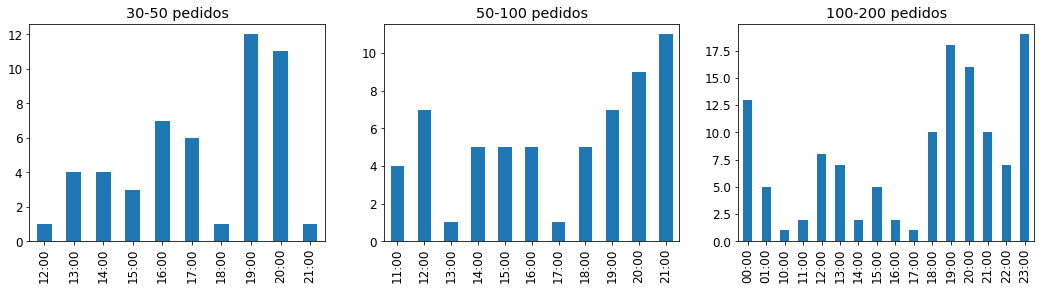

In [9]:
plot_agrupado(amostra_rests, 'Tam Rest', 'Horário Preparo', 'Ident. Pedido', 'count', 3)

### Cálculos taxa de chegada

In [ ]:
grps = amostra_rests.groupby('Tam Rest', sort=False)
t0 = dt.datetime(2023, 1, 10)

Nt = []
for chv, grp in grps:
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    alfas_t = np.array([alfa_t(t, T, b) for t in T])
    As_t = A_t_Riemann(T, b)
    Nt.append({
        'Estab': chv,
        'b': b,
        'T': T,
        'alfa': alfas_t,
        'A': As_t
    })

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))

for N, ax in zip(Nt, axs.ravel()):
    ax.plot(N['A'][0], N['A'][1], label='Estimado')
    ax.plot(*list(zip(*np.array([(t, len(N['T'][N['T'] <= t])) for t in np.sort(N['T'])]))), label='Empírico')
    ax.set_title(N['Estab'])
    ax.legend()
    tks = ax.get_xticks()
    ax.set_xticklabels([(dt.datetime(2023, 1, 10) + dt.timedelta(seconds=int(t * 86400))).strftime('%H:%M') for t in tks])

In [ ]:
for N in Nt:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    print(N['Estab'], round(ks_2samp(emp, est).pvalue, 4))

In [ ]:
pedidos_rests = pedidos.groupby('Estabelecimento').agg(pedidos_rest=('Ident. Pedido', 'count')).reset_index()
pedidos_rests['Tam Rest'] = pedidos_rests['pedidos_rest'].apply(lambda x: '>200' if x > 200 else '100-200' if x >= 100 else '50-100' if x >= 50 else '30-50' if x >=30 else '10-30')
pedidos = pedidos.merge(pedidos_rests, on='Estabelecimento')

In [ ]:
grps = pedidos.groupby('Estabelecimento')
NtT = []
for chv, grp in grps:
    print(chv)
    T = (grp['Início Preparo'] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, epanechnikov), Bounds(0.0001, float('inf')))
    As_t = A_t_Riemann(T, b)
    NtT.append({'Est': chv, 'Tam': grp['Tam Rest'].unique()[0], 'T': T, 'b': b, 'A': As_t})

import json

def conversor(x):
    if hasattr(x, 'tolist'):
        return x.tolist()
    raise TypeError(x)
    
with open('./temp_json', 'w') as arquivo:
    arquivo.write(json.dumps(NtT, indent=4, default=conversor))

In [ ]:
with open('./temp_json') as arquivo:
    NtT_json = np.array(json.loads(arquivo.read()))

In [ ]:
pvalues = []
for N in NtT:
    emp = np.array([len(N['T'][N['T'] <= t]) for t in np.sort(N['T'])])
    est = N['A'][1]
    pvalues.append({'Tam': N['Tam'], 'pvalue': ks_2samp(emp, est).pvalue})

In [ ]:
df_pvalues = pd.DataFrame(pvalues)
df_pvalues['c'] = 'c'

In [ ]:
df_pvalues.groupby('Tam').apply(lambda x: round((x.pvalue > 0.05).sum() / x.pvalue.count(), 4))

In [ ]:
def distancia(lat1, lon1, lat2, lon2):
    return math.acos(
        math.sin(math.radians(lat1)) * math.sin(math.radians(lat2)) + 
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(lon1) - math.radians(lon2))
    ) * 6371.

### Cálculo Tempos de Serviço

In [ ]:
pedidos['Distancia'] = pedidos.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
def t0(d0, v0):
    return d0 / v0

In [ ]:
pdd_terc = pedidos[pedidos['Tipo Entrega'] == 'MERCHANT']

In [ ]:
pdd_terc['TP'] = 3
pdd_terc['Ttau'] = pdd_terc['Distancia'] / 25 * 60
pdd_terc['TC'] = pdd_terc['Ttau'] + pdd_terc['TP']
pdd_terc['d_TC'] = pdd_terc['TC'].apply(lambda x: math.floor(x)) + 1

In [ ]:
pdd_prim = pedidos[pedidos['Tipo Entrega'] == 'IFOOD']

In [ ]:
pdd_prim['TC'] = pdd_prim.apply(lambda x: (x['Término Entrega'] - x['Início Entrega']).total_seconds()  / 60, axis=1)
pdd_prim['d_TC'] = pdd_prim.apply(lambda x: math.floor(x['TC']) + 1, axis=1)

In [ ]:
rests_cross = amostra_rests[['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates().merge(pdd_prim[['Estabelecimento', 'Lat Estab.', 'Lon Estab.']].drop_duplicates(), how='cross')
rests_cross = rests_cross[rests_cross['Estabelecimento_x'] != rests_cross['Estabelecimento_y']]
rests_cross['distancia_rests'] = rests_cross.apply(lambda x: distancia(x['Lat Estab._x'], x['Lon Estab._x'], x['Lat Estab._y'], x['Lon Estab._y']), axis=1)
rests_proximos = rests_cross[rests_cross['distancia_rests'] <= 2]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, l, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    ax.hist(pdds_proximos['TC'].values, bins=20, density=True)
    x = np.linspace(*pdds_proximos['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}\nK: {1}, θ: {2}'.format(chv, round(a, 2), round(b, 2)))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, l, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    probplot(pdds_proximos['TC'].values, (a, 0, b), 'gamma', fit=True, plot=ax)
    ax.set_title(chv)
    ax.set_title('{0}\np-value: {1}'.format(chv, round(kstest(pdds_proximos['TC'].values, 'gamma', (a, l, b)).pvalue, 4)))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_estabs_prox = rests_proximos.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_estabs_prox, axs.ravel()):
    pdds_proximos = grp.merge(pdd_prim, left_on='Estabelecimento_y', right_on='Estabelecimento')
    a, _, b = gamma.fit(pdds_proximos['TC'].values, floc=0)
    pdds_proximos['TC'] = pdds_proximos['Distancia'] / 10 * 60 + 3
    ax.hist(pdds_proximos['TC'].values, bins=20, density=True)
    
    x = np.linspace(*pdds_proximos['TC'].agg(['min', 'max']), 100)
    ax.plot(x, gamma.pdf(x, a, loc=0, scale=b))
    ax.set_title('{0}'.format(chv))

### Cálculo L

In [ ]:
amostra_rests['Distancia'] = amostra_rests.apply(lambda x: distancia(x['Lat Cliente'], x['Lon Cliente'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
max_dists_amostra = amostra_rests.groupby(['Tam Rest', 'Estabelecimento', 'Lat Estab.', 'Lon Estab.'], sort=False).agg(max_dist=('Distancia', 'max')).reset_index()

In [ ]:
max_dists_amostra['max_dist'] = max_dists_amostra['max_dist'].apply(lambda x: math.ceil(x))

In [ ]:
fortaleza = gpd.read_file('Dados_ini/Densidade_Populacional_por_Bairros.zip')

In [ ]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [ ]:
def fazer_grade(x_min, y_min, x_max, y_max, p):
    return [(round(x, 3), round(y, 3)) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)]

In [ ]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 3) for b in fortaleza.geometry.unary_union.bounds)

In [ ]:
grade_completa = fazer_grade(x_min, y_min, x_max, y_max, 0.001)

In [ ]:
plt.scatter(*list(zip(*grade_completa)))

In [ ]:
df_grade_completa = pd.DataFrame(grade_completa, columns=['lon', 'lat'])

In [ ]:
raio_entrega_amostra = max_dists_amostra.merge(df_grade_completa, how='cross')

In [ ]:
raio_entrega_amostra['Distancia'] = raio_entrega_amostra.apply(lambda x: distancia(x['lat'], x['lon'], x['Lat Estab.'], x['Lon Estab.']), axis=1)

In [ ]:
raio_entrega_amostra = raio_entrega_amostra[raio_entrega_amostra['Distancia'] <= raio_entrega_amostra['max_dist']]

In [ ]:
raio_entrega_amostra = gpd.GeoDataFrame(raio_entrega_amostra, geometry=gpd.points_from_xy(raio_entrega_amostra['lon'], raio_entrega_amostra['lat']))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
grp_raios_entrega = raio_entrega_amostra.groupby('Tam Rest', sort=False)

for (chv, grp), ax in zip(grp_raios_entrega, axs.ravel()):
    fortaleza.dissolve().plot(color='lightblue', label='Cidade', ax=ax)
    gpd.sjoin(grp, fortaleza.dissolve(), 'inner', 'within').plot(color='blue', label='Raio', ax=ax)
    ax.scatter(grp['Lon Estab.'], grp['Lat Estab.'], color='red', label='Estab.')
    ax.legend(loc=1)
    ax.set_title('{0}\nL={1}'.format(chv, len(grp)))

### Simulação de fila

In [ ]:
def estim_b(df, t0, chv, uid, ini):
    df = df[df[chv] == uid]
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
    return b

In [ ]:
def estim_lambda(df, chv, uid, ini, t0, t, b, K=norm.pdf):
    df = df[df[chv] == uid]
    t_dec = (t - t0).total_seconds() / 86400
    T = (df[ini] - t0).dt.total_seconds().values / 86400
    a = alfa_t(t_dec, T, b, K)
    return a

In [ ]:
def simula_entradas_fila(lamb, n):
    return poisson.rvs(lamb, size=n)

In [10]:
def V(x, lamb):
    return poisson.pmf(x, lamb)

In [ ]:
def estim_params_tempo_servico(df, chv, uid, tp, adm, lat, lon, ini, fim, max_dist):
    df_estab = df[df[chv] == uid][[chv, lat, lon]].drop_duplicates()
    df_prox = df_estab.merge(df[df[tp] == adm], how='cross')
    df_prox['d'] = df_prox.apply(lambda x: distancia(x[lat+'_x'], x[lon+'_x'], x[lat+'_y'], x[lon+'_y']), axis=1)
    df_prox = df_prox[(df_prox['d'] <= max_dist) & (df_prox[chv+'_x'] != df_prox[chv+'_y'])]
    df_prox['TC'] = df_prox.apply(lambda x: (x[fim] - x[ini]).total_seconds() / 60, axis=1)
    k, l, theta = gamma.fit(df_prox['TC'].values, floc=0)
    return k, theta

In [ ]:
def simula_tempo_servico_discreto(n, k, theta):
    return math.ceil(gamma.rvs(k, loc=0, scale=theta, size=n)[0])

In [11]:
def S(x, k, theta):
    return gamma.cdf(x, k, loc=0, scale=theta) - gamma.cdf(x - 1, k, loc=0, scale=theta)

In [366]:
def estim_k_theta_ts(df, col_ts, delta_t):
    k, l, theta = gamma.fit(df[col_ts].values / delta_t, floc=0)
    return k, theta

In [13]:
def params_espaco_estado(df, lat1, lat2, lon1, lon2, ini, fim, delta_t):
    df['TC'] = df.apply(lambda x: (x[fim] - x[ini]).total_seconds() / 60, axis=1)
    df['d_TC'] = df.apply(lambda x: math.floor(x['TC'] / delta_t) + 1, axis=1)
    m = amostra_rests['d_TC'].max() + 1
    L = amostra_rests[ini].dt.floor('{}min'.format(delta_t)).value_counts()[0] * m
    
    return L, m, df

In [14]:
L, m, df_fila = params_espaco_estado(amostra_rests, 'Lat Cliente', 'Lat Estab.', 'Lon Cliente', 'Lon Estab.', 'Início Entrega', 'Término Entrega', 5)

In [15]:
df_fila['Estabelecimento'].unique()

array([534326, 203669, 688224], dtype=int64)

In [16]:
teste = df_fila[df_fila['Estabelecimento'] == 688224]

In [17]:
t0 = dt.datetime(2023, 1, 10)
T = (teste['Início Preparo'] - t0).dt.total_seconds().values / 86400
b = b_otimo_cv(cv_loglike, 1, (T, norm.pdf), Bounds(0.0001, float('inf')))
alfas_t = np.array([alfa_t(t, T, b) for t in T])

In [18]:
pri_pdd, ult_pdd = teste['Início Entrega'].min() - dt.timedelta(minutes=5), teste['Início Entrega'].max() + dt.timedelta(minutes=5)

In [19]:
T_fila = [(t0 + dt.timedelta(minutes=m * 5) - t0).total_seconds() / 86400 for m in np.arange(1440 / 5)]

In [273]:
Lambda_t_fila

array([[1.64758673e+02],
       [1.79898372e+02],
       [1.90067853e+02],
       [2.00908550e+02],
       [2.11038420e+02],
       [2.16922387e+02],
       [2.18388162e+02],
       [2.21114383e+02],
       [2.19753201e+02],
       [2.16403602e+02],
       [2.13162352e+02],
       [2.06555606e+02],
       [1.96915992e+02],
       [1.89638550e+02],
       [1.79623311e+02],
       [1.70233931e+02],
       [1.59858086e+02],
       [1.48576829e+02],
       [1.34068204e+02],
       [1.19387190e+02],
       [1.06749400e+02],
       [9.39718080e+01],
       [8.13393360e+01],
       [6.91451433e+01],
       [5.76653881e+01],
       [4.71352341e+01],
       [3.77300177e+01],
       [2.95542742e+01],
       [2.26396632e+01],
       [1.69511614e+01],
       [1.23995744e+01],
       [8.85768124e+00],
       [6.17722538e+00],
       [4.20439475e+00],
       [2.79219477e+00],
       [1.80897192e+00],
       [1.14310787e+00],
       [7.04447756e-01],
       [4.23314557e-01],
       [2.48019197e-01],


In [272]:
Lambda_t_fila = np.array([Lambda_t(t, T, b) for t in T_fila])

In [20]:
A_t_parc = np.array([A_t_parcial(i, j, T, b) for i, j in zip(T_fila[1:], T_fila[:-1])])

C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_1012\543021061.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(Lambda_t, xj, xi, (T, b, K))


In [ ]:
#escalas
entrada_1, saida_1 = dt.datetime(2023, 1, 10, 7), dt.datetime(2023, 1, 10, 16)
entrada_2, saida_2 = dt.datetime(2023, 1, 10, 12), dt.datetime(2023, 1, 10, 21)
entrada_3, saida_3 = dt.datetime(2023, 1, 10, 8), dt.datetime(2023, 1, 10, 14)
entrada_4, saida_4 = dt.datetime(2023, 1, 10, 16), dt.datetime(2023, 1, 10, 20)

In [ ]:
escala_1 = [1 if entrada_1 <= t0 + dt.timedelta(seconds=t * 86400) <= saida_1 else 0 for t in T_fila]
escala_2 = [1 if entrada_2 <= t0 + dt.timedelta(seconds=t * 86400) <= saida_2 else 0 for t in T_fila]
escala_3 = [1 if entrada_3 <= t0 + dt.timedelta(seconds=t * 86400) <= saida_3 else 0 for t in T_fila]
escala_4 = [1 if entrada_4 <= t0 + dt.timedelta(seconds=t * 86400) <= saida_4 else 0 for t in T_fila]

In [ ]:
vetor_C = [sum(x) for x in zip(
    escala_1
    ,escala_2 
    ,escala_3
    ,escala_4
)]

In [ ]:
teste['Hora Entrega'] = teste['Início Entrega'].dt.floor('5min')
horas, chegadas = teste['Hora Entrega'].value_counts().reset_index().items()

fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(horas[1], chegadas[1], label='Real')
ax.plot(horas[1], A_t_parc[:,0], label='Estimado', color='orange')

plt.legend()
plt.show()

In [367]:
k, theta = estim_k_theta_ts(teste, 'TC', 5)

# Algoritmos de fila de Brahimi

In [28]:
def remover_tempos_servico(vetores_nx, C):
    for n, xm_xi_x1, p_xm_xi_x1 in vetores_nx:
        rems = np.maximum(xm_xi_x1 - C, 0)
        movs = np.array([np.pad(xi, (1, 0), 'constant', constant_values=0)[:-1] for xi in np.minimum(xm_xi_x1, C)])
        ym_yi_y1 = rems + movs
        n1 = n - np.minimum(xm_xi_x1[:,-1], C).astype(int)
        a = np.sum(ym_yi_y1, axis=1).astype(int)
        
        for vetor_n1_yi_a_px in zip(*(n1, ym_yi_y1, a, p_xm_xi_x1)):
            yield vetor_n1_yi_a_px

In [22]:
def ordenar_n1(vetores_n1_y_a_px):
    for k, g in it.groupby(sorted(vetores_n1_y_a_px, key=itemgetter(0)), lambda x: x[0]):
        yield k, [(v[1], v[2], v[3]) for v in g]

In [23]:
def gerar_vetores_z(nnewst, m):
    def gerar_zm_zi_z1(zj_z1, zm_zi_z1, st):
        if zj_z1 == 0 and st == m:
            z_combs.append(zm_zi_z1.copy())
            return 
        if st == m:
            return
        for zj in range(zj_z1 + 1):
            zm_zi_z1[st] = zj
            gerar_zm_zi_z1(zj_z1 - zj, zm_zi_z1, st + 1)
            zm_zi_z1[st] = 0

    z_combs = []
    zm_zi_z1 = np.zeros(m, dtype=int)
    gerar_zm_zi_z1(nnewst, zm_zi_z1, 0)
    
    return np.array(z_combs)

In [186]:
def gerar_probs_z(nnewst, vetores_z, m, k, theta):
    probs_ts = np.array([S(m - mi, k, theta) for mi in range(m)])
    
    return nnewst / np.prod(factorial(vetores_z), axis=1) * np.prod(probs_ts ** vetores_z, axis=1)

In [184]:
def gerar_vetores_w(vetores_n_x, L, C, m, lamb, k, theta):
    vetores_n1 = ordenar_n1(remover_tempos_servico(vetores_n_x, C))

    for n1, vetores_y_a_px in vetores_n1:
        r_max = L - n1

        for r in range(r_max + 1):
            n2 = min(n1 + r, L)

            for ym_yi_y1, a, p_xm_xi_x1 in vetores_y_a_px:
                nnewst = min(n2, C) - a

                if nnewst == 0: continue
                vetores_z = gerar_vetores_z(nnewst, m)
                probs_z = gerar_probs_z(nnewst, vetores_z, m, k, theta)
                vetores_w = ym_yi_y1 + vetores_z
                probs_w = p_xm_xi_x1 * V(r, lamb) * probs_z

                for n2, wm_wi_w1, p_wm_wi_w1 in zip(*(np.repeat(n2, len(vetores_w)), vetores_w, probs_w)):
                    yield n2, list(wm_wi_w1), p_wm_wi_w1

In [26]:
def somar_probs_w(w):
    for k, g in it.groupby(sorted(w, key=itemgetter(0, 1)), key=lambda x: (x[0], x[1])):
        yield k[0], np.array(k[1]), sum([v[2] for v in g])

In [150]:
def ordenar_vetores_w(w_somado, m):
    probs_w0 = 0
    
    for k, g in it.groupby(sorted(w_somado, key=itemgetter(0)), lambda x: x[0]):
        wm_wi_w1, p_wm_wi_w1 = zip(*[(v[1], v[2]) for v in g])
        probs_w0 += np.sum(p_wm_wi_w1)
        
        yield k, np.array(wm_wi_w1, dtype=int), np.array(p_wm_wi_w1, dtype=float)
        
    yield 0, np.array([np.zeros(m, dtype=int)], dtype=int), np.array([1 - probs_w0])

In [177]:
def matriz_resultados(vetores_w, L):
    matriz = np.zeros((L + 1, L + 1), dtype=float)
    
    for n2, wm_wi_w1, p_wm_wi_w1 in vetores_w:
        matriz[n2, np.sum(wm_wi_w1)] += p_wm_wi_w1
        
    return matriz

In [190]:
def processo_fila(T, L, C, m, lamb, k, theta):
    probs_wt = []
    vetores_0 = (0, np.zeros((1, m), dtype=int), np.array([1.])),
    vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_0, L, C[0], m, lamb[0], k, theta))
    probs_wt.append((T[0], matriz_resultados(vetores_matriz, L)))
    vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)

    for t, c, l in zip(T[1:], C[1:], lamb[1:]):
        #print(dt.datetime.now(), t, c, np.sum(np.sum(probs_wt[-1][1], axis=1) * np.arange(L + 1)))
        if c == 0:
            matriz_sistema_vazio = np.zeros((L + 1, L + 1), dtype=float)
            matriz_sistema_vazio[0, 0] == 1.
            probs_wt.append((t, matriz_sistema_vazio))
            vetores_prox_x = (0, np.zeros((1, m), dtype=int), np.array([1.])),
            continue
            
        vetores_w, vetores_matriz = it.tee(gerar_vetores_w(vetores_prox_x, L, c, m, l, k, theta))
        probs_wt.append((t, matriz_resultados(vetores_matriz, L)))
        vetores_prox_x = ordenar_vetores_w(somar_probs_w(vetores_w), m)
        
    return probs_wt

In [ ]:
Ls = np.sum(np.sum(probs_wt[-1][1], axis=1) * np.arange(L+1))

In [ ]:
Lq = np.sum(np.sum(probs_wt[-1][1], axis=1)[4:] * (np.arange(4, L+1) - C))

In [ ]:
Wq = Lq / (lamb)

In [ ]:
Ws = Ls / lamb

In [ ]:
Ls, Lq, Ws, Wq

In [303]:
1/Lambda_t_fila

array([[6.06948321e-03],
       [5.55869398e-03],
       [5.26127898e-03],
       [4.97738897e-03],
       [4.73847370e-03],
       [4.60994375e-03],
       [4.57900277e-03],
       [4.52254615e-03],
       [4.55055943e-03],
       [4.62099518e-03],
       [4.69125992e-03],
       [4.84131135e-03],
       [5.07830770e-03],
       [5.27318945e-03],
       [5.56720613e-03],
       [5.87426955e-03],
       [6.25554845e-03],
       [6.73052458e-03],
       [7.45889008e-03],
       [8.37610801e-03],
       [9.36773412e-03],
       [1.06414894e-02],
       [1.22941746e-02],
       [1.44623317e-02],
       [1.73414249e-02],
       [2.12155518e-02],
       [2.65040957e-02],
       [3.38360534e-02],
       [4.41702683e-02],
       [5.89930080e-02],
       [8.06479297e-02],
       [1.12896363e-01],
       [1.61884979e-01],
       [2.37846363e-01],
       [3.58141205e-01],
       [5.52800177e-01],
       [8.74808082e-01],
       [1.41955169e+00],
       [2.36230950e+00],
       [4.03194597e+00],


In [372]:
L = 60
m = 9
C1 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 1 for t in T_fila]
_lamb = a_t_fila[1:]
_theta = theta

probs_estab_c1 = processo_fila(T_fila, L, C1, m, _lamb, k, _theta)

In [373]:
L = 40
m = 9
C2 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 2 for t in T_fila]
_lamb = a_t_fila[1:]
_theta = theta

probs_estab_c2 = processo_fila(T_fila, L, C2, m, _lamb, k, _theta)

In [374]:
L = 30
m = 9
C3 = [0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else 3 for t in T_fila]
_lamb = a_t_fila[1:]
_theta = theta

probs_estab_c3 = processo_fila(T_fila, L, C3, m, _lamb, k, _theta)

In [392]:
_lamb.reshape(1, -1)[0]

array([1.43918698e+00, 1.55793322e+00, 1.66040124e+00, 1.74411917e+00,
       1.80768655e+00, 1.85074714e+00, 1.87385070e+00, 1.87823249e+00,
       1.86554829e+00, 1.83760648e+00, 1.79613570e+00, 1.74261940e+00,
       1.67821726e+00, 1.60377957e+00, 1.51994582e+00, 1.42730434e+00,
       1.32657883e+00, 1.21880186e+00, 1.10543695e+00, 9.88420374e-01,
       8.70109333e-01, 7.53142000e-01, 6.40232808e-01, 5.33938779e-01,
       4.36437353e-01, 3.49352015e-01, 2.73650687e-01, 2.09626511e-01,
       1.56955198e-01, 1.14810874e-01, 8.20155671e-02, 5.71965313e-02,
       3.89295810e-02, 2.58536553e-02, 1.67497400e-02, 1.05843321e-02,
       6.52266441e-03, 3.91957923e-03, 2.29647404e-03, 1.31175599e-03,
       7.30434939e-04, 3.96478312e-04, 2.09769969e-04, 1.08176572e-04,
       5.43716012e-05, 2.66345585e-05, 1.27157189e-05, 5.91626635e-06,
       2.68260519e-06, 1.18538708e-06, 5.10447692e-07, 2.14202282e-07,
       8.75938674e-08, 3.49056491e-08, 1.35545897e-08, 5.12911461e-09,
      

In [421]:
L = 60
L_c1 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c1]
Lq_c1 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c1, C1)]
Wq_c1 = Lq_c1 / _theta
Ws_c1 = L_c1 / _theta

In [422]:
L = 40
L_c2 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c2]
Lq_c2 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c2, C2)]
Wq_c2 = Lq_c2 / _theta
Ws_c2 = L_c2 / _theta

In [423]:
L = 30
L_c3 = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_c3]
Lq_c3 = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_c3, C3)]
Wq_c3 = Lq_c3 / _theta
Ws_c3 = L_c3 / _theta

In [238]:
n_real = []

for t in T_fila:
    check = t0 + dt.timedelta(seconds=t * 86400)
    n = len(teste[((teste['Término Entrega'] > check) & (teste['Início Entrega'] <= check)) | 
              ((teste['Término Entrega'] >= check - dt.timedelta(minutes=5)) & (teste['Término Entrega'] < check))])
    n_real.append(n)

In [239]:
x = [t0 + dt.timedelta(seconds=t * 86400) for t in T_fila[1:]]

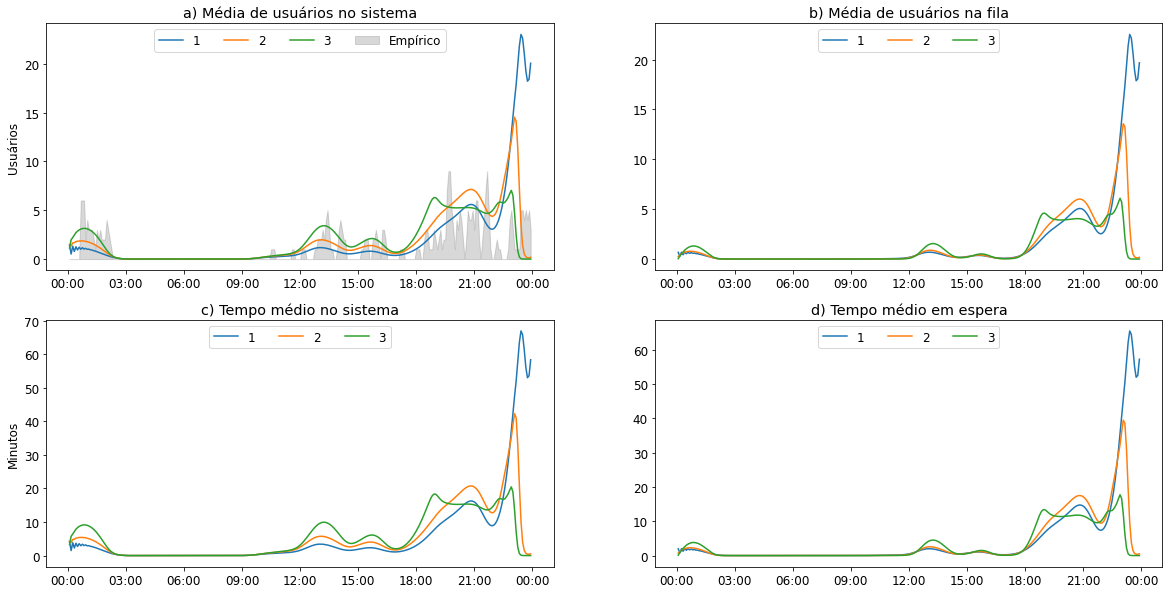

In [425]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

fmt = md.DateFormatter('%H:%M')

axs[0, 0].plot(x, L_c1, label='1')
axs[0, 0].plot(x, L_c2, label='2')
axs[0, 0].plot(x, L_c3, label='3')
axs[0, 0].fill_between(x, n_real[1:], color='gray', alpha=.3, label='Empírico')
axs[0, 0].set_title('a) Média de usuários no sistema')
axs[0, 0].set_ylabel('Usuários')

axs[0, 1].plot(x, Lq_c1, label='1')
axs[0, 1].plot(x, Lq_c2, label='2')
axs[0, 1].plot(x, Lq_c3, label='3')
axs[0, 1].set_title('b) Média de usuários na fila')

axs[1, 0].plot(x, Ws_c1, label='1')
axs[1, 0].plot(x, Ws_c2, label='2')
axs[1, 0].plot(x, Ws_c3, label='3')
axs[1, 0].set_title('c) Tempo médio no sistema')
axs[1, 0].set_ylabel('Minutos')

axs[1, 1].plot(x, Wq_c1, label='1')
axs[1, 1].plot(x, Wq_c2, label='2')
axs[1, 1].plot(x, Wq_c3, label='3')
axs[1, 1].set_title('d) Tempo médio em espera')

for ax in axs.ravel(): 
    ax.xaxis.set_major_formatter(fmt)
    ax.legend(loc='upper center', ncol=4)

In [413]:
L = 30
m = 9
C_escala = [
    0 if dt.datetime(2023, 1, 10, 3) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 9) else
    1 if dt.datetime(2023, 1, 10, 9) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 13) else 
    2 if dt.datetime(2023, 1, 10, 13) <= t0 + dt.timedelta(seconds=t * 86400) < dt.datetime(2023, 1, 10, 18) else
    3 
    for t in T_fila]
_lamb = a_t_fila[1:]
_theta = theta
probs_estab_escala = processo_fila(T_fila, L, C_escala, m, _lamb, k, _theta)

In [426]:
L_escala = [np.sum(np.sum(m, axis=1) * np.arange(L+1)) for _, m in probs_estab_escala]
Lq_escala = [np.sum(np.sum(m[c+1:], axis=1) * (np.arange(c+1, L+1) - c)) for (_, m), c in zip(probs_estab_escala, C_escala)]
Wq_escala = Lq_escala / _theta
Ws_escala = L_escala / _theta

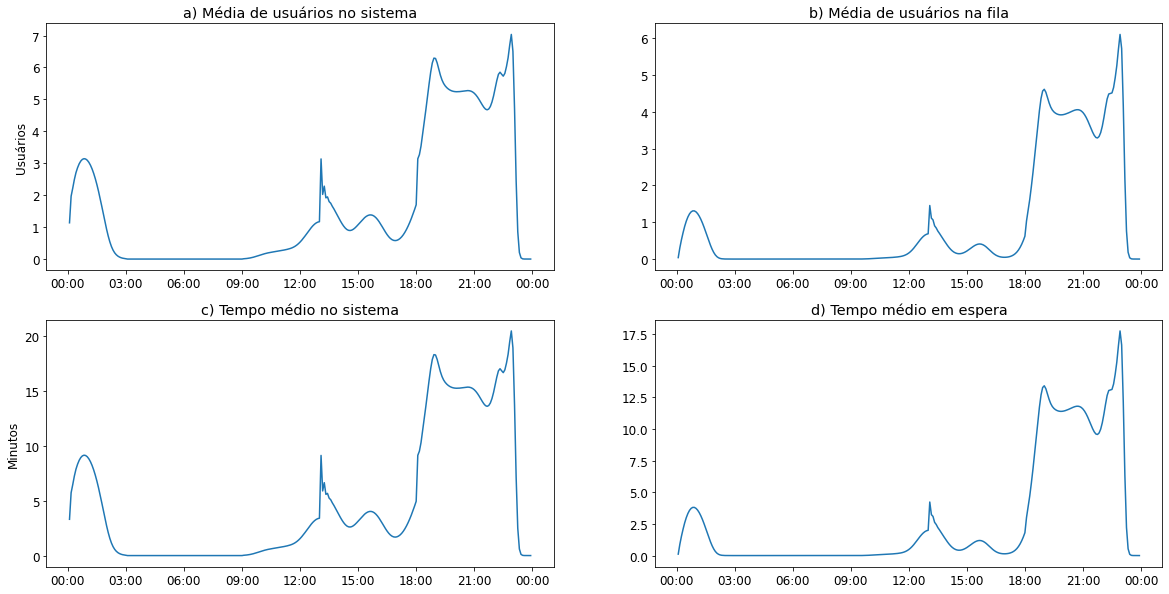

In [432]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

fmt = md.DateFormatter('%H:%M')

axs[0, 0].plot(x, L_escala)
axs[0, 0].set_title('a) Média de usuários no sistema')
axs[0, 0].set_ylabel('Usuários')
axs[0, 1].plot(x, Lq_escala)
axs[0, 1].set_title('b) Média de usuários na fila')
axs[1, 0].plot(x, Ws_escala)
axs[1, 0].set_title('c) Tempo médio no sistema')
axs[1, 0].set_ylabel('Minutos')
axs[1, 1].plot(x, Wq_escala)
axs[1, 1].set_title('d) Tempo médio em espera')

for ax in axs.ravel(): 
    ax.xaxis.set_major_formatter(fmt)

In [428]:
sum([1 for l, c in zip(L_c1, C1) if l > c]) / len(T_fila)

0.3194444444444444

In [429]:
sum([1 for l, c in zip(L_c2, C2) if l > c]) / len(T_fila)

0.2222222222222222

In [430]:
sum([1 for l, c in zip(L_c3, C3) if l > c]) / len(T_fila)

0.2638888888888889

In [431]:
sum([1 for l, c in zip(L_escala, C_escala) if l > c]) / len(T_fila)

0.2604166666666667